最近对比特币的波动率做了一些分析，中间啰啰嗦嗦有些心血来潮的分析，索性将一些理解和代码分享如下，本人能力有限，代码写的脏乱差，如有错误，还请社区大佬多多指（Du）正（Da）。

# 1、金融的时间序列简述

金融的时间序列（Time Series）是基于一个变量以时间维度进行观测，得出的一组随机过程（Stochastic Process）序列模型，这个变量通常为资产的收益率， 因为收益率与投资规模无关，而且具有统计性质，所以对标的金融资产的投资机会分析更有价值。

这里大胆地假设比特币收益率符合一般金融资产的收益率特征，即为弱平稳序列，这可以通过若干样本的一致性检测来实证。

## 1-1、准备工作，导入库，封装函数

腐妹子的研究环境配置很齐全，这里就导入后续计算所需要的库，因为是断断续续写完，所以可能导入上有些冗余，请自行cleanup

In [50]:
'''
start: 2020-02-01 00:00:00
end: 2020-03-01 00:00:00
period: 1h
exchanges: [{"eid":"Huobi","currency":"BTC_USDT","stocks":0}]
'''
from __future__ import absolute_import, division, print_function
from fmz import * # 导入所有FMZ函数
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.graphics.api import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox as lb_test
from scipy import stats
from arch import arch_model
from datetime import timedelta
from itertools import product
from math import sqrt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

task = VCtx(__doc__) # 初始化，验证FMZ对历史数据的读取
print(exchange.GetAccount())

{'Balance': 10000.0, 'FrozenBalance': 0.0, 'Stocks': 0.0, 'FrozenStocks': 0.0}


### 封装部分函数，后面会用，如有来源见注释

In [78]:
# 绘图函数
def tsplot(y, y_2, lags=None, title='', figsize=(18, 8)):  # 源码: https://tomaugspurger.github.io/modern-7-timeseries.html
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    ts2_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y_2.plot(ax=ts2_ax)
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, ts2_ax, acf_ax, pacf_ax

# 性能评价
def mae(observation, forecast):    
    error = mean_absolute_error(observation, forecast)
    print('Mean Absolute Error (MAE): {:.3g}'.format(error))
    return error

def mape(observation, forecast): 
    observation, forecast = np.array(observation), np.array(forecast)
    # Might encounter division by zero error when observation is zero
    error = np.mean(np.abs((observation - forecast) / observation)) * 100
    print('Mean Absolute Percentage Error (MAPE): {:.3g}'.format(error))
    return error

def rmse(observation, forecast):
    error = sqrt(mean_squared_error(observation, forecast))
    print('Root Mean Square Error (RMSE): {:.3g}'.format(error))
    return error

def evaluate(pd_dataframe, observation, forecast):
    first_valid_date = pd_dataframe[forecast].first_valid_index()
    mae_error = mae(pd_dataframe[observation].loc[first_valid_date:, ], pd_dataframe[forecast].loc[first_valid_date:, ])
    mape_error = mape(pd_dataframe[observation].loc[first_valid_date:, ], pd_dataframe[forecast].loc[first_valid_date:, ])
    rmse_error = rmse(pd_dataframe[observation].loc[first_valid_date:, ], pd_dataframe[forecast].loc[first_valid_date:, ]) 

    ax = pd_dataframe.loc[:, [observation, forecast]].plot(figsize=(18,5))
    ax.xaxis.label.set_visible(False)
    return

## 1-2、先粗略了解比特币的历史数据

从统计的角度，我们可以看看比特币的一些数据特征，以过去1年的数据描述为例，收益率以简单收益率计算方式，即收盘价取对数相减为例，公式如下：

$$
r_{t}=\ln ^{\frac{P_{t}}{P_{t-1}}}
$$

In [3]:
df = get_bars('huobi.btc_usdt', '1d', count=10000, start='2019-01-01')
btc_year = pd.DataFrame(df['close'],dtype=np.float)
btc_year.index.name = 'date'
btc_year.index = pd.to_datetime(btc_year.index)
btc_year['log_price'] = np.log(btc_year['close'])
btc_year['log_return'] = btc_year['log_price'] - btc_year['log_price'].shift(1)
btc_year['log_return_100x'] = np.multiply(btc_year['log_return'], 100)

btc_year_test = pd.DataFrame(btc_year['log_return'].dropna(), dtype=np.float)
btc_year_test.index.name = 'date'
mean = btc_year_test.mean()
std = btc_year_test.std()
normal_result = pd.DataFrame(index=['Mean Value', 'Std Value', 'Skewness Value','Kurtosis Value'], columns=['model value'])
normal_result['model value']['Mean Value'] = ('%.4f'% mean[0])
normal_result['model value']['Std Value'] = ('%.4f'% std[0])
normal_result['model value']['Skewness Value'] = ('%.4f'% btc_year_test.skew())
normal_result['model value']['Kurtosis Value'] = ('%.4f'% btc_year_test.kurt())
normal_result

,model value
Mean Value,0.0016
Std Value,0.0341
Skewness Value,-0.6819
Kurtosis Value,7.2243


尖峰厚尾（Thick fat tails）特征是时间标度越短特征越显著，峰度会随着数据频率的增加而增加，在高频数据下特征会十分明显。

以2019年1月1日至今的日收盘价数据为例，对其对数收益率进行描述性分析，可以看到比特币的简单收益率序列不符合正态分布，且具有明显的尖峰厚尾特征。

序列均值为0.0016，标准差为0.0341，偏度为-0.6819，峰度为7.2243，远高于正态分布，具有尖峰厚尾性。用QQ图来计量检验比特币简单收益率的正态性，如下：

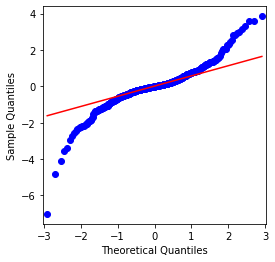

In [4]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
fig = qqplot(btc_year_test['log_return'], line='q', ax=ax, fit=True)

可以看到，QQ图很漂亮，从结果上看，比特币的对数收益率序列不符合正态分布，并且具有明显 “尖峰厚尾”的特征。

接下来，看看波动聚集效应，即金融时间序列在较大幅度的波动后，往往还伴随着更大幅度的波动，而较小波动幅度之后，也通常会紧跟着幅度更小的波动。

波动集群性（Volatility Clustering）反映了波动的正相关和负反馈效应，并于后尾特征高度相关。在计量上，这就意味着波动率的时间序列可能存在自相关性，即当期的波动率可能和上期、上上期甚至上上上期有一定关系。

/usr/local/lib/python3.6/dist-packages/pandas/core/arrays/datetimes.py:1269: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


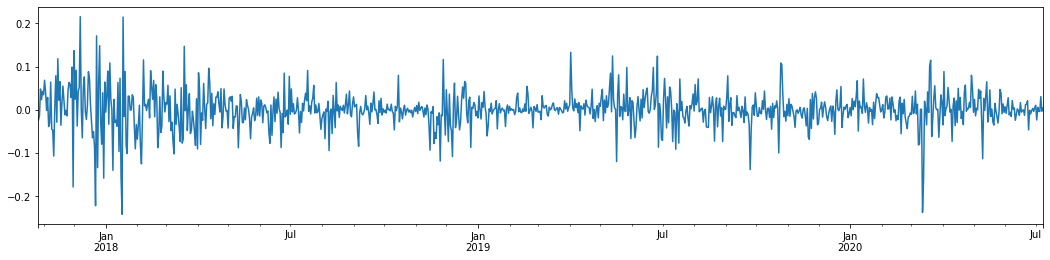

In [5]:
df = get_bars('huobi.btc_usdt', '1d', count=50000, start='2006-01-01')
btc_year = pd.DataFrame(df['close'],dtype=np.float)
btc_year.index.name = 'date'
btc_year.index = pd.to_datetime(btc_year.index)
btc_year['log_price'] = np.log(btc_year['close'])
btc_year['log_return'] = btc_year['log_price'] - btc_year['log_price'].shift(1)
btc_year['log_return_100x'] = np.multiply(btc_year['log_return'], 100)

btc_year_test = pd.DataFrame(btc_year['log_return'].dropna(), dtype=np.float)
btc_year_test.index.name = 'date'
sns.mpl.rcParams['figure.figsize'] = (18, 4)  # 波动率
ax1 = btc_year_test['log_return'].plot()
ax1.xaxis.label.set_visible(False)

取最近3年比特币的日对数收益率并绘制出来，可以明显地看到波动集聚现象。2018年比特币经历了一波大牛市之后，大部分时间都处于平稳姿态。图中最右侧也能看到，2020年3月由于全球金融市场重挫，比特币的流动性也出现挤兑，收益率1天之内暴跌近40%，出现了剧烈的负向波动。

总之，直观的观察，一个较大的波动之后会大概率紧接着一段密集的波动，这也就是波动率的聚集效应。如果这个波动区间可预测，那么对于BTC的短期交易是有一定价值的，这也是探讨波动率的目的。

## 1-3、数据准备

准备训练样本集，先建立一个基准样本，其中以对数收益率为等价的观测波动率。由于当日波动率的不可直接观测性，采用小时数据进行重采样，推断日内已实现波动率，并以此为波动率的因变量。

重采样的方式基于小时数据，如果要用公式表示，如下：

$$
RV_{d_{j+1}}=\sum_{i=1}^{60} r_{t_{t_{i+60}(j+1)}^{2}}
$$

In [8]:
count_num = 100000
start_date = '2020-03-01'

df = get_bars('huobi.btc_usdt', '1m', count=50000, start='2020-02-13')  # 取分钟数据
kline_1m = pd.DataFrame(df['close'], dtype=np.float)
kline_1m.index.name = 'date'
kline_1m['log_price'] = np.log(kline_1m['close'])
kline_1m['return'] = kline_1m['close'].pct_change().dropna()
kline_1m['log_return'] = kline_1m['log_price'] - kline_1m['log_price'].shift(1)

kline_1m['squared_log_return'] = np.power(kline_1m['log_return'], 2)

kline_1m['return_100x'] = np.multiply(kline_1m['return'], 100)
kline_1m['log_return_100x'] = np.multiply(kline_1m['log_return'], 100)  # 放大100倍

df = get_bars('huobi.btc_usdt', '1h', count=860, start='2020-02-13')  # 取小时数据
kline_all = pd.DataFrame(df['close'], dtype=np.float)
kline_all.index.name = 'date'
kline_all['log_price'] = np.log(kline_all['close'])  # 计算每日对数收益率
kline_all['return'] = kline_all['log_price'].pct_change().dropna()
kline_all['log_return'] = kline_all['log_price'] - kline_all['log_price'].shift(1)  # 计算对数收益率
kline_all['squared_log_return'] = np.power(kline_all['log_return'], 2)  # 对数日收益率的指数平方

kline_all['return_100x'] = np.multiply(kline_all['return'], 100)
kline_all['log_return_100x'] = np.multiply(kline_all['log_return'], 100)  # 放大100倍

kline_all['realized_variance_1_hour'] = kline_1m.loc[:, 'squared_log_return'].resample('h', closed='left', label='left').sum().copy() # 重采样至天
kline_all['realized_volatility_1_hour'] = np.sqrt(kline_all['realized_variance_1_hour'])  # 方差开方得波动率

kline_all = kline_all[4:-29] # 由于最后一行缺失，因此去除最后一行
kline_all.head(3)

,close,log_price,return,log_return,squared_log_return,return_100x,log_return_100x,realized_variance_1_hour,realized_volatility_1_hour
date,,,,,,,,,
2020-02-13 12:00:00+08:00,10397.1,9.249282,0.000152,0.001405,0.000002,0.015195,0.140522,0.000016,0.003962
2020-02-13 13:00:00+08:00,10438.0,9.253208,0.000424,0.003926,0.000015,0.042447,0.392607,0.000007,0.002581
2020-02-13 14:00:00+08:00,10449.0,9.254262,0.000114,0.001053,0.000001,0.011383,0.105329,0.000025,0.004995


顺便准备下样本外数据，方式雷同

In [40]:
# 准备样本外数据，带已实现日波动率
df = get_bars('huobi.btc_usdt', '1m', count=50000, start='2020-02-13')  # 取分钟数据
kline_1m = pd.DataFrame(df['close'], dtype=np.float)
kline_1m.index.name = 'date'
kline_1m['log_price'] = np.log(kline_1m['close'])
kline_1m['log_return'] = kline_1m['log_price'] - kline_1m['log_price'].shift(1)
kline_1m['log_return_100x'] = np.multiply(kline_1m['log_return'], 100)  # 放大100倍
kline_1m['squared_log_return'] = np.power(kline_1m['log_return_100x'], 2)
kline_1m#.tail()
df = get_bars('huobi.btc_usdt', '1h', count=860, start='2020-02-13')  # 取小时数据
kline_test = pd.DataFrame(df['close'], dtype=np.float)
kline_test.index.name = 'date'
kline_test['log_price'] = np.log(kline_test['close'])  # 计算每日对数收益率
kline_test['log_return'] = kline_test['log_price'] - kline_test['log_price'].shift(1)  # 计算对数收益率
kline_test['log_return_100x'] = np.multiply(kline_test['log_return'], 100)  # 放大100倍
kline_test['squared_log_return'] = np.power(kline_test['log_return_100x'], 2)  # 对数日收益率的指数平方
kline_test['realized_variance_1_hour'] = kline_1m.loc[:, 'squared_log_return'].resample('h', closed='left', label='left').sum() # 重采样至天
kline_test['realized_volatility_1_hour'] = np.sqrt(kline_test['realized_variance_1_hour'])  # 方差开方得波动率
kline_test = kline_test[4:-2]

为了理解样本的数据基础情况，做一个简单的描述性分析，如下：

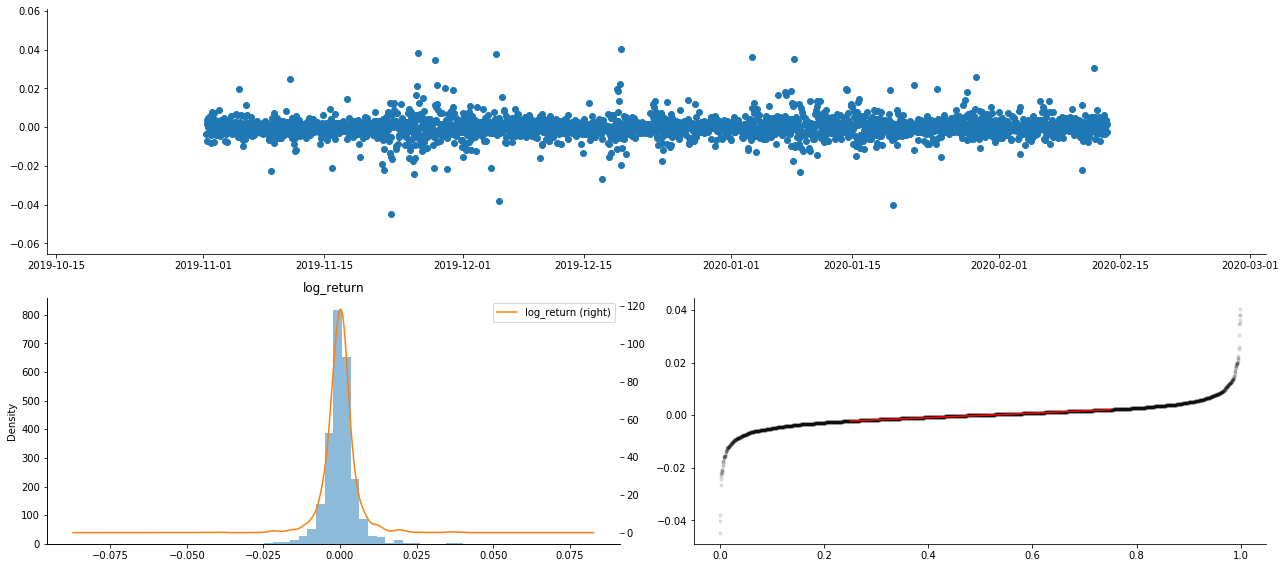

In [9]:
line_test = pd.DataFrame(kline_train['log_return'].dropna(), dtype=np.float)
line_test.index.name = 'date'

mean = line_test.mean()  # 计算均值，标准差
std = line_test.std()

line_test.sort_values(by = 'log_return', inplace = True)  # 重新排序
s_r = line_test.reset_index(drop = False)  # 重新排序后，更新index
s_r['p'] = (s_r.index - 0.5) / len(s_r)  # 计算百分位数 p(i)
s_r['q'] = (s_r['log_return'] - mean) / std  # 计算q值

st = line_test.describe()
x1 ,y1 = 0.25, st['log_return']['25%']
x2 ,y2 = 0.75, st['log_return']['75%']

fig = plt.figure(figsize = (18,8))
layout = (2, 2)
ax1 = plt.subplot2grid(layout, (0, 0), colspan=2)# 绘制数据分布图
ax2 = plt.subplot2grid(layout, (1, 0))# 绘制直方图
ax3 = plt.subplot2grid(layout, (1, 1))# 绘制QQ图，直线为四分之一位数、四分之三位数的连线，基本符合正态分布

ax1.scatter(line_test.index, line_test.values)
line_test.hist(bins=30,alpha = 0.5,ax = ax2)
line_test.plot(kind = 'kde', secondary_y=True,ax = ax2)
ax3.plot(s_r['p'],s_r['log_return'],'k.',alpha = 0.1)
ax3.plot([x1,x2],[y1,y2],'-r')
sns.despine()
plt.tight_layout()

从结果上看，对数收益率的时序图形中，具有明显的波动聚集和杠杆效应。

对数收益率的分布图中偏度小于0，说明样本内的收益率略微负，右偏。对数收益率的QQ图中，可以看到对数收益率分布非正态。

数据分布的偏度小于1，说明样本内的收益率略微正，略右偏。峰度值大于3，说明收益率服从尖峰重尾分布。

既然都到这一步了，就再做个统计量检验吧。

In [10]:
line_test = pd.DataFrame(kline_train['log_return'].dropna(), dtype=np.float)
line_test.index.name = 'date'
mean = line_test.mean()
std = line_test.std()
normal_result = pd.DataFrame(index=['Mean Value', 'Std Value', 'Skewness Value','Kurtosis Value',
                                    'Ks Test Value','Ks Test P-value',
                                    'Jarque Bera Test','Jarque Bera Test P-value'],
                    columns=['model value'])
normal_result['model value']['Mean Value'] = ('%.4f'% mean[0])
normal_result['model value']['Std Value'] = ('%.4f'% std[0])
normal_result['model value']['Skewness Value'] = ('%.4f'% line_test.skew())
normal_result['model value']['Kurtosis Value'] = ('%.4f'% line_test.kurt())
normal_result['model value']['Ks Test Value'] = stats.kstest(line_test, 'norm', (mean, std))[0]
normal_result['model value']['Ks Test P-value'] = stats.kstest(line_test, 'norm', (mean, std))[1]
normal_result['model value']['Jarque Bera Test'] = stats.jarque_bera(line_test)[0]
normal_result['model value']['Jarque Bera Test P-value'] = stats.jarque_bera(line_test)[1]
normal_result

,model value
Mean Value,0.0001
Std Value,0.0053
Skewness Value,0.3393
Kurtosis Value,12.5200
Ks Test Value,1
Ks Test P-value,0
Jarque Bera Test,16304.6
Jarque Bera Test P-value,0


分别采用Kolmogorov - Smirnov和Jarque - Bera检验统计量，原假设分别是具备显著性差异和正态分布特性，如果P值小于0.05%置信水平临界值，则拒绝原假设。

可以看到，峰度值大于3，呈现尖峰厚尾的特征，KS和JB的P值小于置信区间，拒绝正态分布假设，证明BTC的收益率不具备正态分布特性，实证存在尖峰厚尾的特性。

## 1-4、已实现波动率和观测波动率的比较

我们将squared_log_return（对数收益率平方）和realized_variance（已实现方差）合并观察。

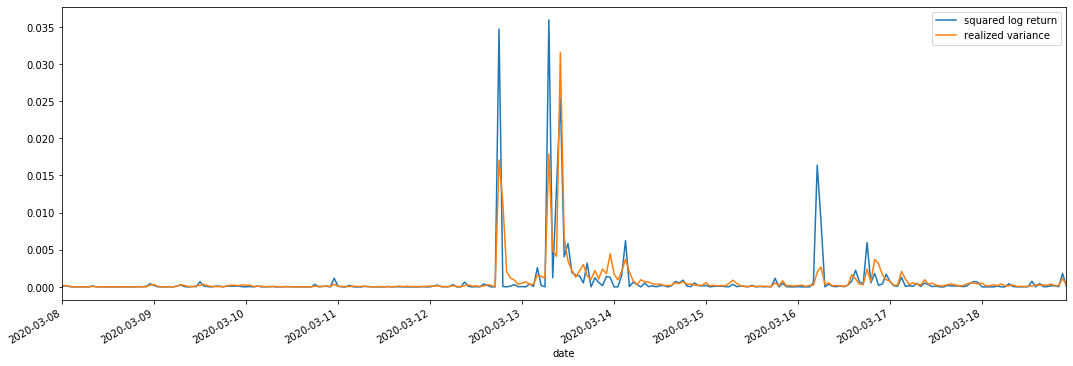

In [11]:
fig, ax = plt.subplots(figsize=(18, 6))
start = '2020-03-08 00:00:00+08:00'
end = '2020-03-20 00:00:00+08:00'

np.abs(kline_all['squared_log_return']).loc[start:end].plot(ax=ax,label='squared log return')
kline_all['realized_variance_1_hour'].loc[start:end].plot(ax=ax,label='realized variance')
plt.legend(loc='best')

可以看到已实现方差幅度更大的时候，收益率的幅度也较高，已实现收益率更平滑，两者都容易观察到明显的聚集效应。

单纯从理论的角度上讲，RV更接近真实的波动率，而日内波动率由于属于隔夜数据，短周期内的波动是被抹平了的，所以从观测的角度上讲，日内波动率更适合低频一点的股市。BTC的高频交易和7X24小时市场特性，更适合采用RV来确定为基准波动率。

# 2、时间序列的平稳性

如果是一条非平稳的序列，就需要将其近似调整为平稳的序列。常用的方式是做差分处理，理论上，经过多次差分后，非平稳的序列均都能近似成为一个平稳序列。如果样本序列的协方差平稳，其观测值的期望和方差，以及协方差都不会随着时间变化而变化，表明该样本序列在统计分析上更便于推断。

这里采用单位根检验法，即ADF检验。ADF检验采用t检验来观测显著性，要求序列原则上没有表现出明显的趋势时，就仅保留常数项，如果序列存在趋势，则回归方程即要包括常数项，也要包括时间趋势项。另外还可以基于信息准则，分别使用AIC和BIC准则来评价，非要写公式的话如下：

$$\begin{eqnarray}
&&AIC = -2 \ln L + 2 k \\
&&BIC = -2 \ln L + \ln n \cdot k \\
\end{eqnarray}$$

In [16]:
stable_test = kline_all['log_return']
adftest = sm.tsa.stattools.adfuller(np.array(stable_test), autolag='AIC')
adftest2 = sm.tsa.stattools.adfuller(np.array(stable_test), autolag='BIC')
output=pd.DataFrame(index=['ADF Statistic Test Value', "ADF P-value", "Lags", "Number of Observations",
                           "Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"],
                    columns=['AIC','BIC'])
output['AIC']['ADF Statistic Test Value'] = adftest[0]
output['AIC']['ADF P-value'] = adftest[1]
output['AIC']['Lags'] = adftest[2]
output['AIC']['Number of Observations'] = adftest[3]
output['AIC']['Critical Value(1%)'] = adftest[4]['1%']
output['AIC']['Critical Value(5%)'] = adftest[4]['5%']
output['AIC']['Critical Value(10%)'] = adftest[4]['10%']
output['BIC']['ADF Statistic Test Value'] = adftest2[0]
output['BIC']['ADF P-value'] = adftest2[1]
output['BIC']['Lags'] = adftest2[2]
output['BIC']['Number of Observations'] = adftest2[3]
output['BIC']['Critical Value(1%)'] = adftest2[4]['1%']
output['BIC']['Critical Value(5%)'] = adftest2[4]['5%']
output['BIC']['Critical Value(10%)'] = adftest2[4]['10%']
output

,AIC,BIC
ADF Statistic Test Value,-5.66129,-31.7186
ADF P-value,9.36685e-07,0
Lags,19,0
Number of Observations,807,826
Critical Value(1%),-3.43848,-3.43829
Critical Value(5%),-2.86513,-2.86505
Critical Value(10%),-2.56868,-2.56864


原假设为序列不存在单位根，即非平稳性，备择假设序列是平稳的。检验P值远小于0.05%的置信水平临界值，拒绝原假设，所以对数收益率为平稳序列，可以使用统计时序模型进行建模。

# 3、模型识别和定阶

为了建立均值方程，需要对序列做自相关性检验，确保误差项不存在自相关性。首先，试着绘制自相关ACF和偏相关PACF图，如下：

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc10d0370f0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc10ce8a898>)

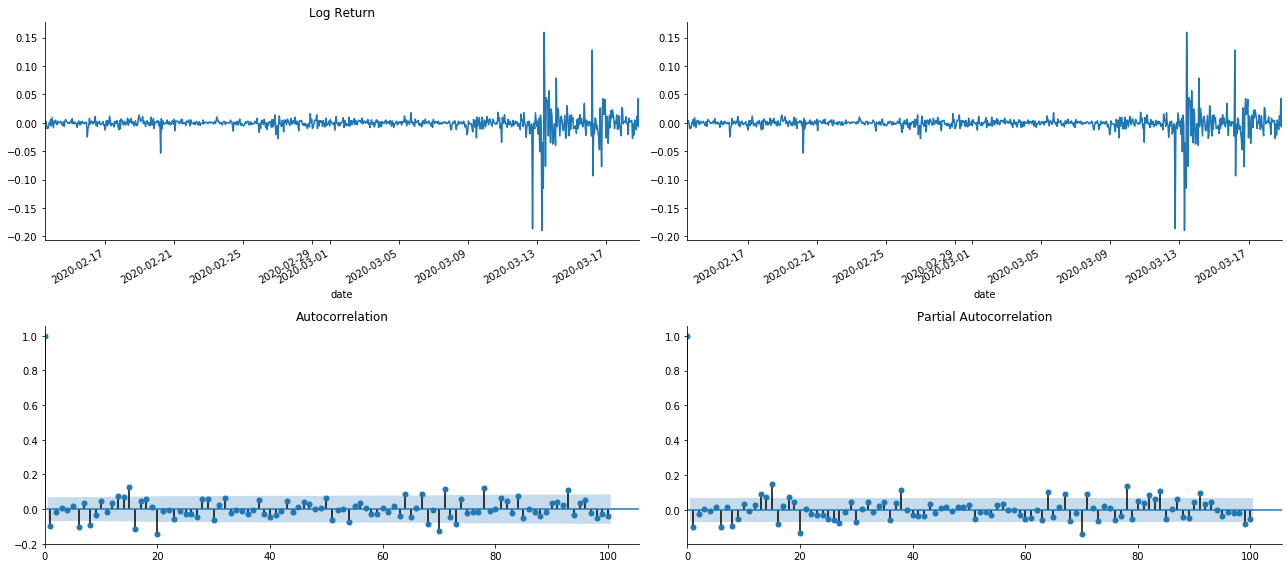

In [19]:
tsplot(kline_all['log_return'], kline_all['log_return'], title='Log Return', lags=100)

可以看到截尾的效果很漂亮，有那么一瞬间这图给了我一个启发，那就是市场真是无效的么？为了验证，接着对收益率序列做自相关分析，并且还要确定模型的滞后阶数。

常用的相关系数是衡量自己和自己的相关程度，即$r(t)$和过去某个时间$r(t-l)$的相关性：

$$\rho_l = \frac{Cov(r_t, r_{t-l})}{\sqrt{Var(r_t)Var(r_{t-l})}} = \frac{Cov(r_t, _{t-l})}{Var(r_t)}$$

接着就计量检验一下，原假设为所有自相关系数为0，即序列不存在自相关性，检验统计量公式这么写

$$Q(m) = T(T+2)\sum_{l=1}^{m} \frac{\hat{\rho}_l^2}{T-l}$$

取10个自相关系数做分析，如下：

In [20]:
acf,q,p = sm.tsa.acf(kline_all['log_return'], nlags=15,unbiased=True,qstat = True, fft=False)  # 检验10个自相关系数
output = pd.DataFrame(np.c_[range(1,16), acf[1:], q, p], columns=['lag', 'ACF', 'Q', 'P-value'])
output = output.set_index('lag')
output

,ACF,Q,P-value
lag,,,
1.0,-0.099665,8.244485,0.004088
2.0,-0.015185,8.436110,0.014727
3.0,0.005439,8.460726,0.037390
4.0,-0.007983,8.513819,0.074469
5.0,0.015917,8.725129,0.120543
6.0,-0.102288,17.462134,0.007727
7.0,0.032860,18.364914,0.010428
8.0,-0.090556,25.229481,0.001421
9.0,-0.035358,26.277304,0.001840


根据检验统计量Q和P值可以看到，自相关函数ACF在0阶后逐渐为0，Q检验统计量的P值都足够小，可以拒绝原假设，故序列存在自相关性。

# 4、ARMA建模

AR和MA模型挺简单的，简单说下，Markdown写公式太累了，有兴趣的大家自己查吧。AR（Autoregression，自回归）模型主要是对时间序列进行建模，如果序列已经通过了ACF检验，也就是间隔为1的自相关系数显著，即在$t-1$时刻的数据$r_(t-1)$，对预测t时刻$r_t$时可能是有用的。

MA（Moving Average，滑动平均）模型是使用过去q个时期的随机干扰或预测误差，来线性表达当前的预测值。

为了更充分地描述数据的动态结构，需要提高AR或MA模型的阶数，但这样的参数会让计算变得更复杂，所以为了简化这个过程，就提出了自回归滑动平均 (ARMA) 模型。

由于价格时间序列一般都是非平稳性的，而前面曾讨论了差分法对平稳性的优化效果，所以ARIMA(p,d,q) （求和自回归移动平均）模型就是在现有模型对序列应用的基础上增加了d阶差分处理。不过我们已经用了对数，那就直接使用ARMA(p,q)即可。

插一句，ARIMA模型同ARMA的模型建立过程，唯一的区别在于，如果分析平稳性之后，得出不稳定的结果，那么模型将直接对序列做二次差分然后再进行平稳性检验，直到平稳后再定阶p和q，构建完整模型并对其评价，然后再做后续预测，省掉了回退做差分的步骤。但是，价格的二阶差分已经没意义了，所以就ARMA吧。

## 4-1、定阶

接下来可以直接通过信息准则定阶，我用AIC和BIC的热力图来试试。

AIC best param: (0, 1, 1)
BIC best param: (0, 1, 1)
HQIC best param: (0, 1, 1)
Best Param Selected: (0, 1, 1)


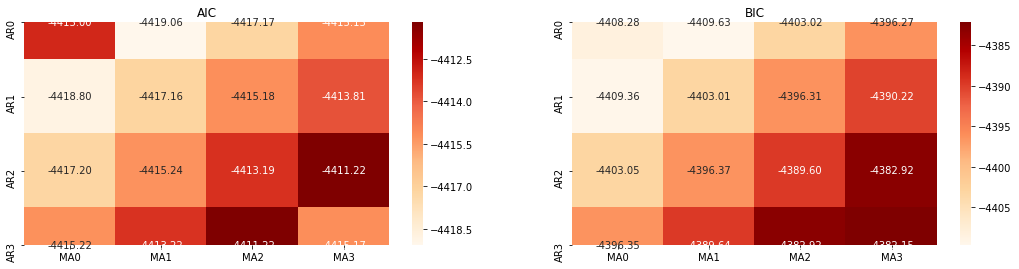

In [22]:
def select_best_params():
    ps = range(0, 4)
    ds= range(1, 2)
    qs = range(0, 4)
    parameters = product(ps, ds, qs)
    parameters_list = list(parameters)

    p_min = 0
    d_min = 0
    q_min = 0
    p_max = 3
    d_max = 3
    q_max = 3

    results_aic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                               columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])
    results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                               columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])
    
    best_params = []
    aic_results = []
    bic_results = []
    hqic_results = []
    best_aic = float("inf")
    best_bic = float("inf")
    best_hqic = float("inf")
    warnings.filterwarnings('ignore')
    for param in parameters_list:
        try:
            model = sm.tsa.SARIMAX(kline_all['log_price'], order=(param[0], param[1], param[2])).fit(disp=-1)
            results_aic.loc['AR{}'.format(param[0]), 'MA{}'.format(param[2])] = model.aic
            results_bic.loc['AR{}'.format(param[0]), 'MA{}'.format(param[2])] = model.bic
        except ValueError:
            continue    
           
        aic_results.append([param, model.aic])
        bic_results.append([param, model.bic])
        hqic_results.append([param, model.hqic])
    
    results_aic = results_aic[results_aic.columns].astype(float)
    results_bic = results_bic[results_bic.columns].astype(float)
    
    # 绘制AIC和BIC的热力图，寻找最优
    fig = plt.figure(figsize=(18, 9))
    layout = (2, 2)
    aic_ax = plt.subplot2grid(layout, (0, 0))
    bic_ax = plt.subplot2grid(layout, (0, 1))

    aic_ax = sns.heatmap(results_aic,mask=results_aic.isnull(),ax=aic_ax,cmap='OrRd',annot=True,fmt='.2f',);
    aic_ax.set_title('AIC');
    bic_ax = sns.heatmap(results_bic,mask=results_bic.isnull(),ax=bic_ax,cmap='OrRd',annot=True,fmt='.2f',);
    bic_ax.set_title('BIC');
    
    aic_df = pd.DataFrame(aic_results)
    aic_df.columns = ['params', 'aic']   
    best_params.append(aic_df.params[aic_df.aic.idxmin()])
    print('AIC best param: {}'.format(aic_df.params[aic_df.aic.idxmin()]))
    
    bic_df = pd.DataFrame(bic_results)
    bic_df.columns = ['params', 'bic']
    best_params.append(bic_df.params[bic_df.bic.idxmin()])
    print('BIC best param: {}'.format(bic_df.params[bic_df.bic.idxmin()]))
    
    hqic_df = pd.DataFrame(hqic_results)
    hqic_df.columns = ['params', 'hqic']
    best_params.append(hqic_df.params[hqic_df.hqic.idxmin()])
    print('HQIC best param: {}'.format(hqic_df.params[hqic_df.hqic.idxmin()]))

    for best_param in best_params:
        if best_params.count(best_param)>=2:
            print('Best Param Selected: {}'.format(best_param))
            return best_param 

best_param = select_best_params()

可以明显看到，对对数价格的最优1阶参数组合为(0,1,1)，简单粗暴。对log_return（对数收益率）执行同样运算，AIC最优为(4,3)，BIC最优为(0,1)。所以对log_return（对数收益率）取最优的参数组合为(0,1)。

## 4-2、ARMA建模拟合

不需要季度性系数，但SARIMAX的属性更丰富，所以决定选择这个模型进行建模，并顺便画出描述性分析，如下：

In [26]:
params = (0, 0, 1)
training_model = smt.SARIMAX(endog=kline_all['log_return'], trend='c', order=params, seasonal_order=(0, 0, 0, 0))
model_results = training_model.fit(disp=False)
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:             log_return   No. Observations:                  827
Model:               SARIMAX(0, 0, 1)   Log Likelihood                2215.932
Date:                Wed, 08 Jul 2020   AIC                          -4425.864
Time:                        04:29:32   BIC                          -4411.710
Sample:                    02-13-2020   HQIC                         -4420.435
                         - 03-18-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0008      0.001     -1.399      0.162      -0.002       0.000
ma.L1         -0.1021      0.010    -10.163      0.000      -0.122      -0.082
sigma2         0.0003   2.82e-06     97.828      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                      104.77   Jarque-Bera (JB):            106398.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              24.60   Skew:                            -2.68
Prob(H) (two-sided):                  0.00   Kurtosis:                        58.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

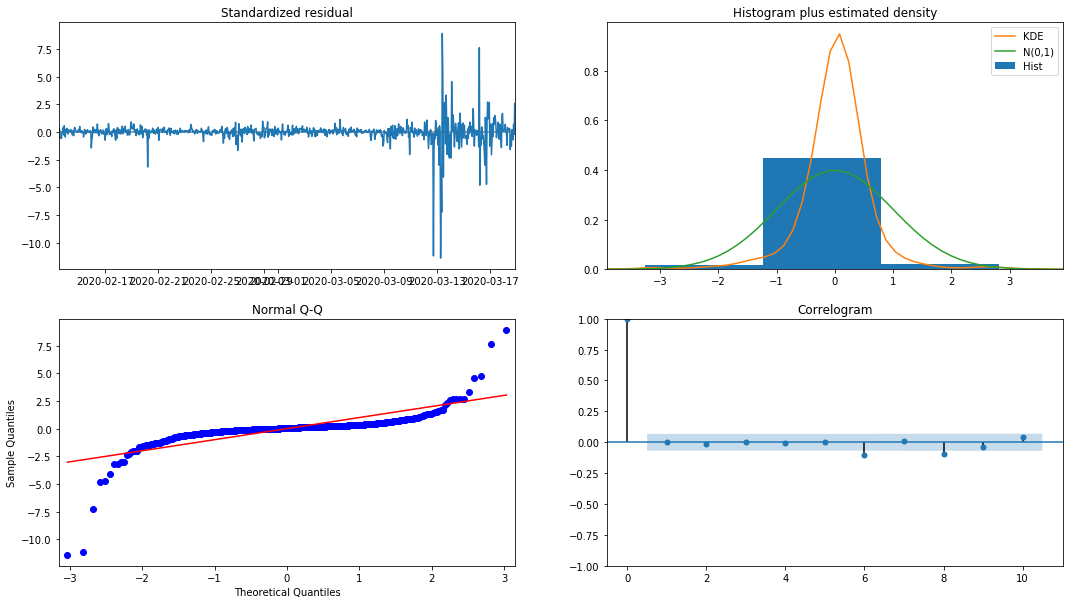

In [27]:
model_results.plot_diagnostics(figsize=(18, 10));

直方图中概率密度KDE和正态分布N(0,1)比较远，表明残差不是正态分布。QQ分位图中，从标准正态分布抽取的样本中，残差没有完全服从线性趋势，所以再次确认残差不是正态分布，更接近白噪声。

那说了这些，模型能不能用，还得检验一下。

## 4-3、模型检验

残差的拟合效果不够理想，于是我们对其执行Durbin Watson检验。检验的原假设为序列不存在自相关性，备择假设序列是平稳的。另外，如果LB、JB和H检验的P值均小于0.05%置信水平临界值，就拒绝原假设。

In [28]:
het_method='breakvar'
norm_method='jarquebera'
sercor_method='ljungbox'

(het_stat, het_p) = model_results.test_heteroskedasticity(het_method)[0]
norm_stat, norm_p, skew, kurtosis = model_results.test_normality(norm_method)[0]

sercor_stat, sercor_p = model_results.test_serial_correlation(method=sercor_method)[0]
sercor_stat = sercor_stat[-1] # 最大周期的最后一个值
sercor_p = sercor_p[-1]

dw = sm.stats.stattools.durbin_watson(model_results.filter_results.standardized_forecasts_error[0, model_results.loglikelihood_burn:])

arroots_outside_unit_circle = np.all(np.abs(model_results.arroots) > 1)
maroots_outside_unit_circle = np.all(np.abs(model_results.maroots) > 1)

print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
print('\nDurbin-Watson test on residuals: d={:.2f}\n\t(NB: 2 means no serial correlation, 0=pos, 4=neg)'.format(dw))
print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))

root_test=pd.DataFrame(index=['Durbin-Watson test on residuals','Test for all AR roots outside unit circle (>1)','Test for all MA roots outside unit circle (>1)'],columns=['c'])
root_test['c']['Durbin-Watson test on residuals']=dw
root_test['c']['Test for all AR roots outside unit circle (>1)']=arroots_outside_unit_circle
root_test['c']['Test for all MA roots outside unit circle (>1)']=maroots_outside_unit_circle
root_test

Test heteroskedasticity of residuals (breakvar): stat=24.598, p=0.000

Test normality of residuals (jarquebera): stat=106398.739, p=0.000

Test serial correlation of residuals (ljungbox): stat=104.767, p=0.000

Durbin-Watson test on residuals: d=2.00
	(NB: 2 means no serial correlation, 0=pos, 4=neg)

Test for all AR roots outside unit circle (>1): True

Test for all MA roots outside unit circle (>1): True


,c
Durbin-Watson test on residuals,1.99996
Test for all AR roots outside unit circle (>1),True
Test for all MA roots outside unit circle (>1),True


In [34]:
kline_all['log_price_dif1'] = kline_all['log_price'].diff(1)
kline_all = kline_all[1:]
kline_train = kline_all

training_label = 'log_return'
training_ts = pd.DataFrame(kline_train[training_label], dtype=np.float)

delta = model_results.fittedvalues - training_ts[training_label]
adjR = 1 - delta.var()/training_ts[training_label].var()
adjR_test=pd.DataFrame(index=['adjR2'],columns=['Value'])
adjR_test['Value']['adjR2']=adjR**2
adjR_test

,Value
adjR2,0.000106429


Durbin-Watson测试统计量如果等于2，确认序列没有相关性，其统计值分布在(0,4)之间，接近0意味着正相关性较高，反之接近4意味着负相关性较高。这里约等于2。其他检验的P值足够小，单位特征根在单位圆之外，修正$adjR²$的值越大越好，整体看来，计量结果并不理想。


In [35]:
model_results.params

intercept   -0.000817
ma.L1       -0.102102
sigma2       0.000275
dtype: float64

综上所述，该定阶参数可以基本上满足对时间序列的建模，支持后续波动率建模的需求，但拟合效果一般。模型表达式如下：

$$
r_t= -0.102102r_(t-1)+0.000275ε_(t-1)-0.000817
$$


## 4-4、模型预测

接下来训练的模型进行向前一步拟合。statsmodels中对拟合和预测提供了静态和动态两种选项，其区别在于预测下一步时是滚动使用观测值，还是迭代使用上一步产生的预测值，对log_return（对数收益率）的预测效果分别如下：

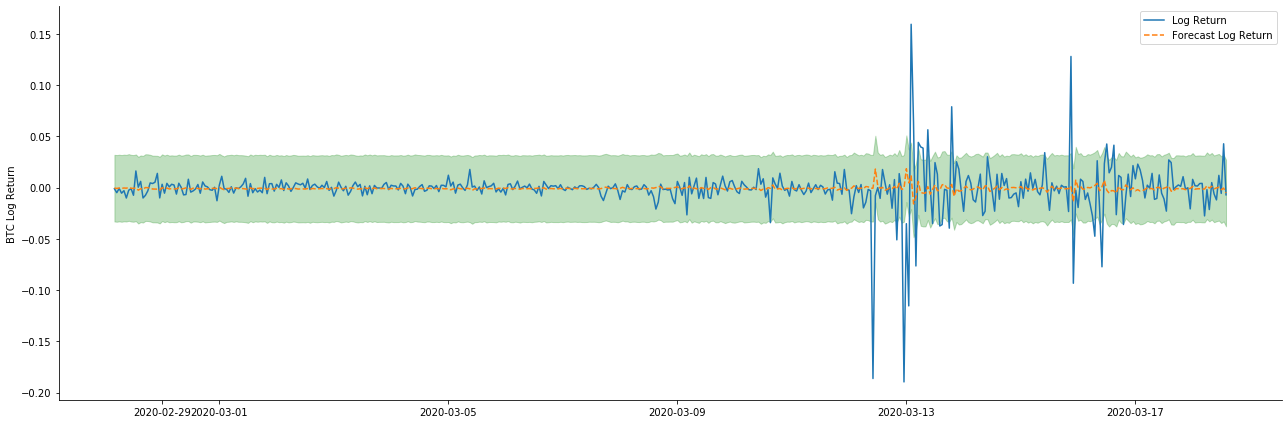

In [37]:
start_date = '2020-02-28 12:00:00+08:00'
end_date = start_date 

pred_dy = model_results.get_prediction(start=start_date, dynamic=False)
pred_dy_ci = pred_dy.conf_int()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
ax.plot(kline_all['log_return'].loc[start_date:], label='Log Return', linestyle='-')
ax.plot(pred_dy.predicted_mean.loc[start_date:], label='Forecast Log Return', linestyle='--')
ax.fill_between(pred_dy_ci.index,pred_dy_ci.iloc[:, 0],pred_dy_ci.iloc[:, 1], color='g', alpha=.25)

plt.ylabel("BTC Log Return")
plt.legend(loc='best')
plt.tight_layout()
sns.despine()

可以看到，静态模式对样本内的拟合效果很出色，样本数据几乎可以被95%的置信区间覆盖，动态模式有点放飞。

所以接下来就看看动态模式下的数据拟合效果：

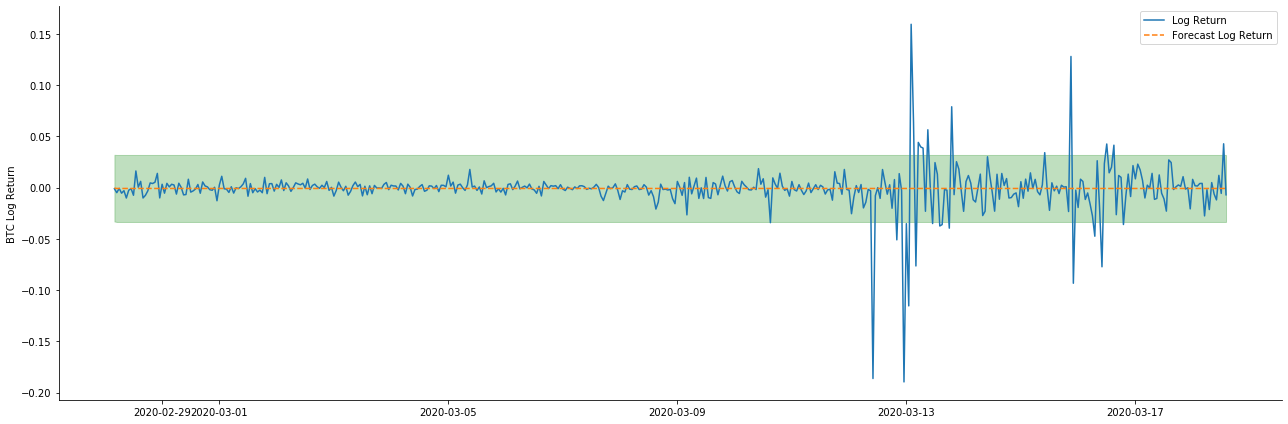

In [38]:
start_date = '2020-02-28 12:00:00+08:00'
end_date = start_date 

pred_dy = model_results.get_prediction(start=start_date, dynamic=True)
pred_dy_ci = pred_dy.conf_int()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))
ax.plot(kline_all['log_return'].loc[start_date:], label='Log Return', linestyle='-')
ax.plot(pred_dy.predicted_mean.loc[start_date:], label='Forecast Log Return', linestyle='--')
ax.fill_between(pred_dy_ci.index,pred_dy_ci.iloc[:, 0],pred_dy_ci.iloc[:, 1], color='g', alpha=.25)

plt.ylabel("BTC Log Return")
plt.legend(loc='best')
plt.tight_layout()
sns.despine()

可以看到，两种模式对样本内的拟合效果都很出色，均值几乎都可以被95%的置信区间覆盖，但静态模式明显更贴合。接下来看对样本外的50步，即向前50小时的预测效果：

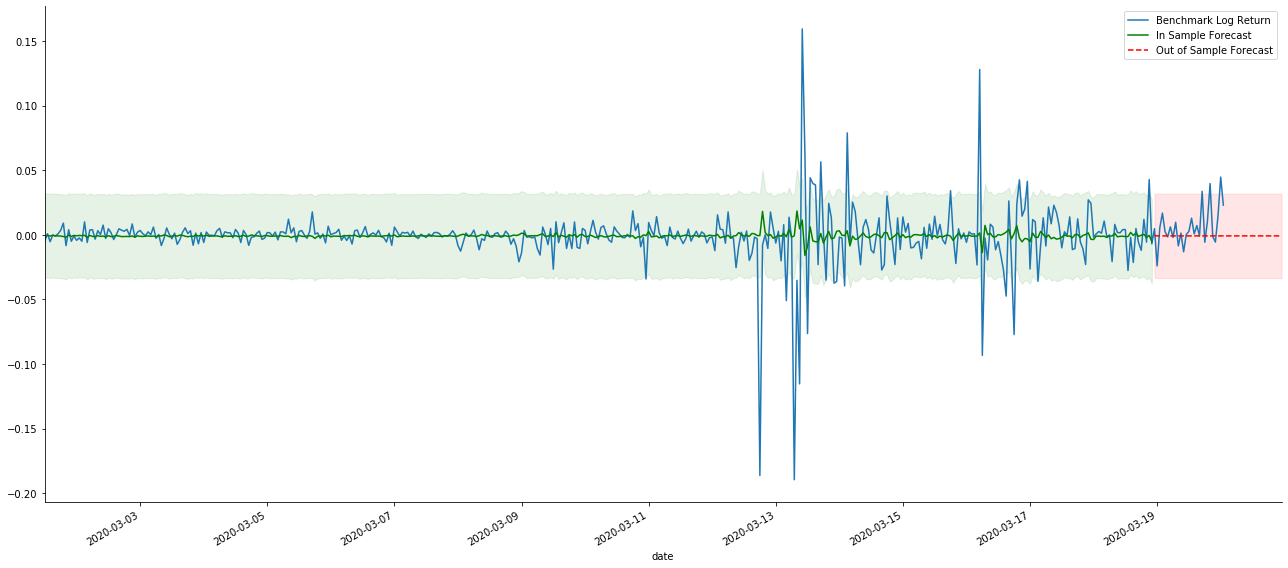

In [41]:
# 样本外的预测数据 predict()
start_date = '2020-03-01 12:00:00+08:00'
end_date = '2020-03-20 23:00:00+08:00'
model = False

predict_step = 50
predicts_ARIMA_normal = model_results.get_prediction(start=start_date, dynamic=model, full_reports=True)
ci_normal = predicts_ARIMA_normal.conf_int().loc[start_date:]

predicts_ARIMA_normal_out = model_results.get_forecast(steps=predict_step, dynamic=model)
ci_normal_out = predicts_ARIMA_normal_out.conf_int().loc[start_date:end_date]

fig, ax = plt.subplots(figsize=(18,8))
kline_test.loc[start_date:end_date, 'log_return'].plot(ax=ax, label='Benchmark Log Return')

predicts_ARIMA_normal.predicted_mean.plot(ax=ax, style='g', label='In Sample Forecast')
ax.fill_between(ci_normal.index, ci_normal.iloc[:,0], ci_normal.iloc[:,1], color='g', alpha=0.1)

predicts_ARIMA_normal_out.predicted_mean.loc[:end_date].plot(ax=ax, style='r--', label='Out of Sample Forecast')
ax.fill_between(ci_normal_out.index, ci_normal_out.iloc[:,0], ci_normal_out.iloc[:,1], color='r', alpha=0.1)

plt.tight_layout()
plt.legend(loc='best')
sns.despine()

由于样本内数据的拟合是滚动向前一步预测，所以在样本内信息量充足时，静态模式反而容易出现过度拟合，而动态模式缺少可靠的因变量，迭代多步之后效果越来越差。在对样本外数据进行预测时，模型等同于样本内的动态模式，所以长期预测的误差项准确度必然会较低。

如果我们将收益率预测反推回log_price（对数价格），拟合如下图所示：

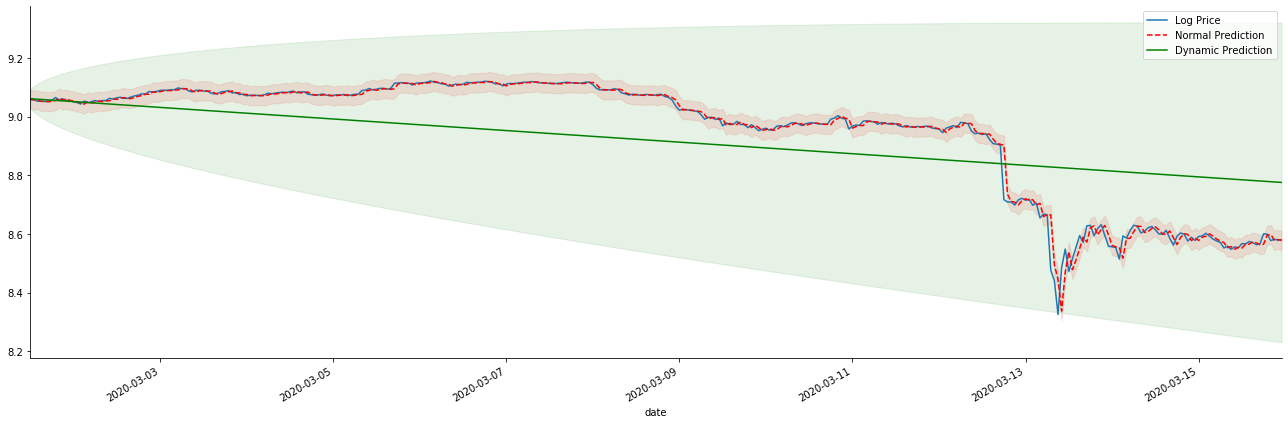

In [42]:
params = (0, 1, 1)
mod = smt.SARIMAX(endog=kline_all['log_price'], trend='c', order=params, seasonal_order=(0, 0, 0, 0))
res = mod.fit(disp=False)

start_date = '2020-03-01 12:00:00+08:00'
end_date = '2020-03-15 23:00:00+08:00'

predicts_ARIMA_normal = res.get_prediction(start=start_date, dynamic=False, full_results=False)
predicts_ARIMA_dynamic = res.get_prediction(start=start_date, dynamic=True, full_results=False)

fig, ax = plt.subplots(figsize=(18,6))
kline_test.loc[start_date:end_date, 'log_price'].plot(ax=ax, label='Log Price')

predicts_ARIMA_normal.predicted_mean.loc[start_date:end_date].plot(ax=ax, style='r--', label='Normal Prediction')
ci_normal = predicts_ARIMA_normal.conf_int().loc[start_date:end_date]
ax.fill_between(ci_normal.index, ci_normal.iloc[:,0], ci_normal.iloc[:,1], color='r', alpha=0.1)

predicts_ARIMA_dynamic.predicted_mean.loc[start_date:end_date].plot(ax=ax, style='g', label='Dynamic Prediction')
ci_dynamic = predicts_ARIMA_dynamic.conf_int().loc[start_date:end_date]
ax.fill_between(ci_dynamic.index, ci_dynamic.iloc[:,0], ci_dynamic.iloc[:,1], color='g', alpha=0.1)

plt.tight_layout()
plt.legend(loc='best')
sns.despine()

图中很容易看出静态模式下的拟合优势，和动态模式在长期预测上的极差表现。这红色的虚线，粉红的区间····你不能说这模型的预测有误吧，毕竟完全覆盖了均线的走势，但····有意义吗？

其实ARMA的模型本身没有错，因为问题并不是出在模型本身，而是出在事物本身的客观逻辑上。时间序列模型本身需要基于前后观测的关联才能建立，因此对于白噪音的序列是不可能建模的，所以前面做的这么多，都基于一个大胆的假设，那就是BTC的收益率序列不能是独立同分布。

而一般来讲，收益率序列都是鞅差（Martingale difference）序列，这意味着收益率是不可预测的，对应市场的弱有效性假设成立。我们假设了个别样本中的收益率具有一定的自相关性，同分布假设也是为了让拟合的模型可以适用于训练集，这样才能够为了拟合而拟合出一个简单的ARMA模型，那这样的预测效果必然是很差的。

不过拟合之后的残差序列也是鞅差序列，鞅差序列不一定是独立同分布的，但是条件方差可以是依赖于过去的值，所以一阶的自相关性没有了，但是依然存在着高阶的自相关性，这也是波动率可以被建模和观测的重要前提。

如果这样的逻辑成立，那么建立各种波动率模型的前提也就成立了。所以对于一个收益率序列而言，如果满足了市场弱有效，那么均值一定是很难预测的，但是方差是可以预测的。而拟合的ARMA提供了一个质量尚可的时间序列基准，那么其质量的高低也就决定了波动率的预测质量高低。

最后，还是简单评价一下预测的效果吧。以误差为评价基准，样本内和样本外的指标分别如下：

In [61]:
start = '2020-02-14 00:00:00+08:00'
predicts_ARIMA_normal = model_results.get_prediction(dynamic=False)
predicts_ARIMA_dynamic = model_results.get_prediction(dynamic=True)
training_label = 'log_return'

compare_ARCH_X = pd.DataFrame()
compare_ARCH_X['Model'] = ['NORMAL','DYNAMIC']
compare_ARCH_X['RMSE'] = [rmse(predicts_ARIMA_normal.predicted_mean[1:], kline_test[training_label][:826]),
                          rmse(predicts_ARIMA_dynamic.predicted_mean[1:], kline_test[training_label][:826])]
compare_ARCH_X['MAPE'] = [mape(predicts_ARIMA_normal.predicted_mean[:50], kline_test[training_label][:50]),
                          mape(predicts_ARIMA_dynamic.predicted_mean[:50], kline_test[training_label][:50])]
compare_ARCH_X

Root Mean Square Error (RMSE): 0.0184
Root Mean Square Error (RMSE): 0.0167
Mean Absolute Percentage Error (MAPE): 2.25e+03
Mean Absolute Percentage Error (MAPE): 395


,Model,RMSE,MAPE
0,NORMAL,0.018382,2249.756029
1,DYNAMIC,0.016694,395.233251


可以看到，静态模型在预测值与真实值的误差吻合度上，略优于动态模式，较好地拟合了比特币的对数收益率，基本符合预期。动态预测缺少更准确的变量信息，误差也被迭代放大，所以预测效果较差。MAPE都大于100%，所以两个模型的实际拟合品质都不理想。

In [62]:
predict_step = 50
predicts_ARIMA_normal_out = model_results.get_forecast(steps=predict_step, dynamic=False)
predicts_ARIMA_dynamic_out = model_results.get_forecast(steps=predict_step, dynamic=True)
testing_ts = kline_test
training_label = 'log_return'

compare_ARCH_X = pd.DataFrame()
compare_ARCH_X['Model'] = ['NORMAL','DYNAMIC']
compare_ARCH_X['RMSE'] = [get_rmse(predicts_ARIMA_normal_out.predicted_mean, testing_ts[training_label]),
                          get_rmse(predicts_ARIMA_dynamic_out.predicted_mean, testing_ts[training_label])]
compare_ARCH_X['MAPE'] = [get_mape(predicts_ARIMA_normal_out.predicted_mean, testing_ts[training_label]),
                          get_mape(predicts_ARIMA_dynamic_out.predicted_mean, testing_ts[training_label])]
compare_ARCH_X

,Model,RMSE,MAPE
0,NORMAL,0.01664,1399.597537
1,DYNAMIC,0.01664,1399.597537


由于样本外的下一步预测依赖上一步的结果，所以只有动态模式有效，而动态模式本身的长期误差缺陷，导致整体模型的预测能力不足，所以顶多也就预测下一步。

综上所述，ARMA模型静态模式适用于拟合比特币的样本内收益率，对收益率的短期预测可以有效覆盖在置信区间内，但长期预测非常困难，满足了市场的弱有效性。经检验，样本区间内的收益率满足后续对波动率观测的前提。

# 5、ARCH效应

ARCH模型效应，也就是条件异方差序列的序列相关性。利用混成检验Ljung-Box检验残差平方序列的相关性，来判断是否具有ARCH效应，如果ARCH效应检验通过，即序列具备异方差特性，就可以进行下一步的GARCH建模，对均值方程和波动率方程进行联合估计。否则需要对模型进行优化重调，例如再做差分处理或取倒数序列。

这里准备一些数据集和全局变量：

In [115]:
count_num = 100000
start_date = '2020-03-01'

df = get_bars('huobi.btc_usdt', '1m', count=count_num, start=start_date)  # 取分钟数据
kline_1m = pd.DataFrame(df['close'], dtype=np.float)
kline_1m.index.name = 'date'
kline_1m['log_price'] = np.log(kline_1m['close'])
kline_1m['return'] = kline_1m['close'].pct_change().dropna()
kline_1m['log_return'] = kline_1m['log_price'] - kline_1m['log_price'].shift(1)

kline_1m['squared_log_return'] = np.power(kline_1m['log_return'], 2)

kline_1m['return_100x'] = np.multiply(kline_1m['return'], 100)
kline_1m['log_return_100x'] = np.multiply(kline_1m['log_return'], 100)  # 放大100倍

df = get_bars('huobi.btc_usdt', '1h', count=count_num, start=start_date)  # 取小时数据
kline_test = pd.DataFrame(df['close'], dtype=np.float)
kline_test.index.name = 'date'
kline_test['log_price'] = np.log(kline_test['close'])  # 计算每日对数收益率
kline_test['return'] = kline_test['log_price'].pct_change().dropna()
kline_test['log_return'] = kline_test['log_price'] - kline_test['log_price'].shift(1)  # 计算对数收益率
kline_test['squared_log_return'] = np.power(kline_test['log_return'], 2)  # 对数日收益率的指数平方

kline_test['return_100x'] = np.multiply(kline_test['return'], 100)
kline_test['log_return_100x'] = np.multiply(kline_test['log_return'], 100)  # 放大100倍

kline_test['realized_variance_1_hour'] = kline_1m.loc[:, 'squared_log_return'].resample('h', closed='left', label='left').sum().copy() # 重采样至天
kline_test['realized_volatility_1_hour'] = np.sqrt(kline_test['realized_variance_1_hour'])  # 方差开方得波动率

kline_test = kline_test[4:-2500]
kline_test

,close,log_price,return,log_return,squared_log_return,return_100x,log_return_100x,realized_variance_1_hour,realized_volatility_1_hour
date,,,,,,,,,
2020-03-01 12:00:00+08:00,8579.52,9.057133,-0.000518,-0.004694,2.203698e-05,-0.051804,-0.469436,0.000030,0.005503
2020-03-01 13:00:00+08:00,8586.87,9.057990,0.000095,0.000856,7.332917e-07,0.009455,0.085632,0.000025,0.004993
2020-03-01 14:00:00+08:00,8541.21,9.052658,-0.000589,-0.005332,2.842605e-05,-0.058861,-0.533161,0.000029,0.005347
2020-03-01 15:00:00+08:00,8539.99,9.052515,-0.000016,-0.000143,2.040530e-08,-0.001578,-0.014285,0.000032,0.005667
2020-03-01 16:00:00+08:00,8532.41,9.051627,-0.000098,-0.000888,7.885138e-07,-0.009809,-0.088798,0.000023,0.004759
...,...,...,...,...,...,...,...,...,...
2020-03-26 09:00:00+08:00,6692.91,8.808804,-0.000815,-0.007185,5.162054e-05,-0.081497,-0.718474,0.000058,0.007614
2020-03-26 10:00:00+08:00,6682.07,8.807183,-0.000184,-0.001621,2.627438e-06,-0.018401,-0.162094,0.000048,0.006957
2020-03-26 11:00:00+08:00,6725.92,8.813724,0.000743,0.006541,4.278336e-05,0.074268,0.654090,0.000054,0.007376


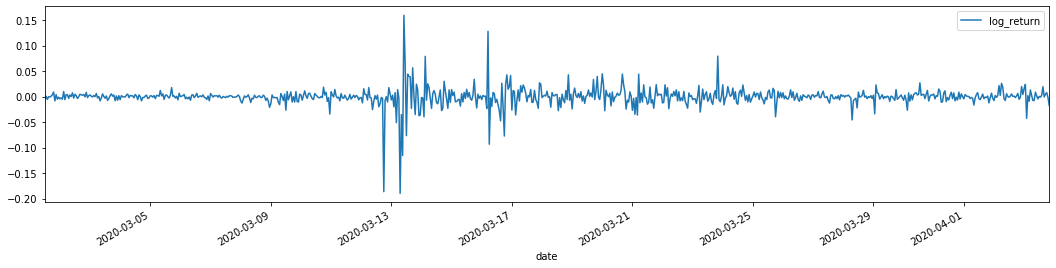

In [93]:
cc = 3
model_p = 1
predict_lag = 30
label = 'log_return'

training_label = label
training_ts = pd.DataFrame(kline_test[training_label], dtype=np.float)

training_arch_label = label
training_arch = pd.DataFrame(kline_test[training_arch_label], dtype=np.float)

training_garch_label = label
training_garch = pd.DataFrame(kline_test[training_garch_label], dtype=np.float)

training_egarch_label = label
training_egarch = pd.DataFrame(kline_test[training_egarch_label], dtype=np.float)

training_arch.plot(figsize = (18,4))

对数收益率如上所示，接下来先需要检验样本的ARCH效应，基于ARMA建立样本内的残差序列，部分序列以及残差和残差的平方序列先算出来：

In [68]:
training_arma_model = smt.SARIMAX(endog=training_ts, trend='c', order=(0, 0, 1), seasonal_order=(0, 0, 0, 0))
arma_model_results = training_arma_model.fit(disp=False)
arma_model_results.summary()
training_arma_fitvalue = pd.DataFrame(arma_model_results.fittedvalues,dtype=np.float)
at = pd.merge(training_ts, training_arma_fitvalue, on='date')
at.columns = ['log_return', 'model_fit']
at['res'] = at['log_return'] - at['model_fit']
at['res2'] = np.square(at['res'])
at.head()

,log_return,model_fit,res,res2
date,,,,
2020-03-01 12:00:00+08:00,-0.004694,-0.000420,-0.004274,1.826666e-05
2020-03-01 13:00:00+08:00,0.000856,-0.000021,0.000878,7.705114e-07
2020-03-01 14:00:00+08:00,-0.005332,-0.000503,-0.004829,2.331489e-05
2020-03-01 15:00:00+08:00,-0.000143,0.000034,-0.000177,3.138139e-08
2020-03-01 16:00:00+08:00,-0.000888,-0.000404,-0.000484,2.345087e-07


然后绘制出样本的残差序列图

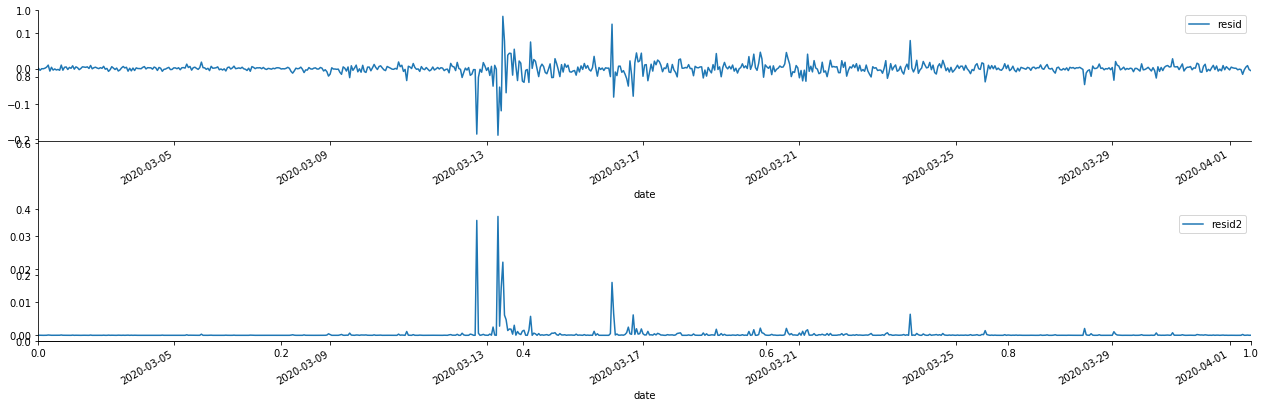

In [69]:
fig, ax = plt.subplots(figsize=(18, 6))
ax1 = fig.add_subplot(2,1,1)
at['res'][1:].plot(ax=ax1,label='resid')
plt.legend(loc='best')

ax2 = fig.add_subplot(2,1,2)
at['res2'][1:].plot(ax=ax2,label='resid2')

plt.legend(loc='best')
plt.tight_layout()
sns.despine()

可以看到，残差序列有明显的聚集特性，可以初步判断该序列具备ARCH效应，同样采取ACF来检验残差平方的自相关性，结果如下。

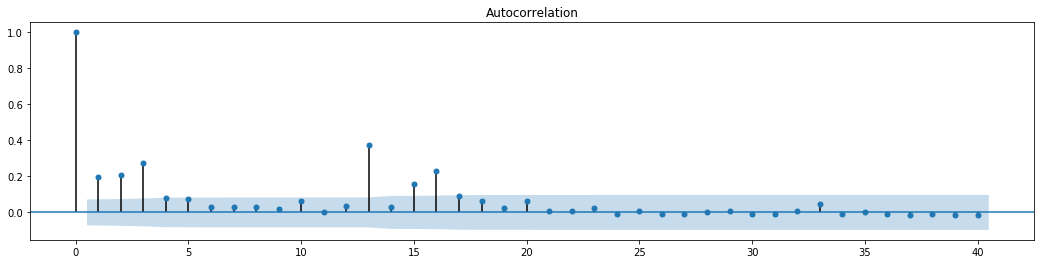

In [70]:
figure = plt.figure(figsize=(18,4))
ax1 = figure.add_subplot(111)
fig = sm.graphics.tsa.plot_acf(at['res2'],lags = 40, ax=ax1)

对序列进行混成检验的原假设是序列没有相关性，可以看到前20阶的数据对应P值均小于0.05%置信水平临界值，所以拒绝原假设，即序列的残差具备ARCH效应，可以通过ARCH类模型进行方差模型的建立，用于拟合残差序列的异方差特性，并进一步预测波动率。

# 6、GARCH建模

在执行GARCH建模前，需要对序列的厚尾部分做一定的处理，因为假设中序列的误差项需要符合正态分布或者t分布，而前面我们已经验证了收益率序列存在厚尾的分布，所以需要对这部分做描述补充。

在GARCH建模中，误差项提供了正态分布、t分布、GED（Generalized Error Distribution，广义误差分布）分布和Skewed Students t分布选项，根据AIC准则，这里用穷举式的联合回归估计，比对了所有选项的结果，得到GED的拟合度是最好的，过程就略了。

其中Normal正态分布拟合度不如t分布，也说明收益率分布比正态分布有更厚的尾端。接下来进入建模过程，对log_return（对数收益率）执行ARMA-GARCH(1,1)模型回归估计如下：

In [73]:
am_GARCH = arch_model(training_garch, mean='AR', vol='GARCH',
                      p=1, q=1, lags=3, dist='ged')
res_GARCH = am_GARCH.fit(disp=False, options={'ftol': 1e-01})
res_GARCH.summary()

Iteration:      1,   Func. Count:     10,   Neg. LLF: -2256.6439906220858


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 AR - GARCH Model Results                                 
==========================================================================================
Dep. Variable:                         log_return   R-squared:                       0.007
Mean Model:                                    AR   Adj. R-squared:                  0.003
Vol Model:                                  GARCH   Log-Likelihood:                2258.93
Distribution:      Generalized Error Distribution   AIC:                          -4501.87
Method:                        Maximum Likelihood   BIC:                          -4464.98
                                                    No. Observations:                  743
Date:                            Wed, Jul 08 2020   Df Residuals:                      735
Time:                                    07:22:47   Df Model:                            8
                                    Mean Model                                   
=================================================================================
                     coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------------------
Const          2.4580e-04  2.232e-04      1.101      0.271 [-1.916e-04,6.832e-04]
log_return[1]     -0.0930  3.753e-02     -2.477  1.324e-02   [ -0.167,-1.941e-02]
log_return[2]     -0.0230  4.156e-02     -0.553      0.580    [ -0.104,5.845e-02]
log_return[3] -6.9438e-03  3.488e-02     -0.199      0.842 [-7.532e-02,6.143e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      7.1055e-06  1.537e-12  4.622e+06      0.000 [7.106e-06,7.106e-06]
alpha[1]       0.1000  1.661e-02      6.021  1.734e-09   [6.745e-02,  0.133]
beta[1]        0.8800  1.101e-02     79.942      0.000     [  0.858,  0.902]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.5000      0.432      3.469  5.232e-04 [  0.652,  2.348]
========================================================================

Covariance estimator: robust
"""

根据ARCH库对GARCH波动率方程描述：

$$
\sigma_{t}^{2}=\omega_{0}+\sum_{i=1}^{p} a_{1} \epsilon_{t-i}^{2}+\sum_{k=1}^{q} \beta_{1} \sigma_{t-k}^{2}
$$

可以得到波动率的条件回归方程为：

$$
\sigma_{t}^{2}=0.0000071055+0.1 \epsilon_{t-1}^{2}+0.88 \sigma_{t-1}^{2}
$$

结合拟合的预测波动率，与样本的已实现波动率进行比较，看看效果。


Mean Absolute Error (MAE): 0.0132
Mean Absolute Percentage Error (MAPE): 95.4
Root Mean Square Error (RMSE): 0.0186


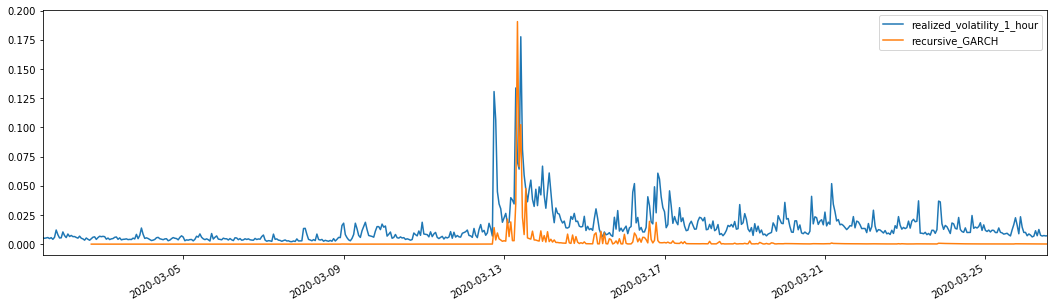

In [116]:
def recursive_forecast(pd_dataframe):     
    window = predict_lag
    model = 'GARCH'
    index = kline_test[1:].index
    end_loc = np.where(index >= kline_test.index[window])[0].min()
    forecasts = {}
    for i in range(len(kline_test[1:]) - window + 2):
        mod = arch_model(pd_dataframe['log_return'][1:], mean='AR', vol=model, dist='ged',p=1, q=1)
        res = mod.fit(last_obs=i+end_loc, disp='off', options={'ftol': 1e03})
        temp = res.forecast().variance
        fcast = temp.iloc[i + end_loc - 1]
        forecasts[fcast.name] = fcast

    forecasts = pd.DataFrame(forecasts).T
    pd_dataframe['recursive_{}'.format(model)] = forecasts['h.1']
    evaluate(pd_dataframe, 'realized_volatility_1_hour', 'recursive_{}'.format(model))

recursive_forecast(kline_test)

为了比较，顺手做个ARCH的，如下：

Mean Absolute Error (MAE): 0.0141
Mean Absolute Percentage Error (MAPE): 98.3
Root Mean Square Error (RMSE): 0.0206


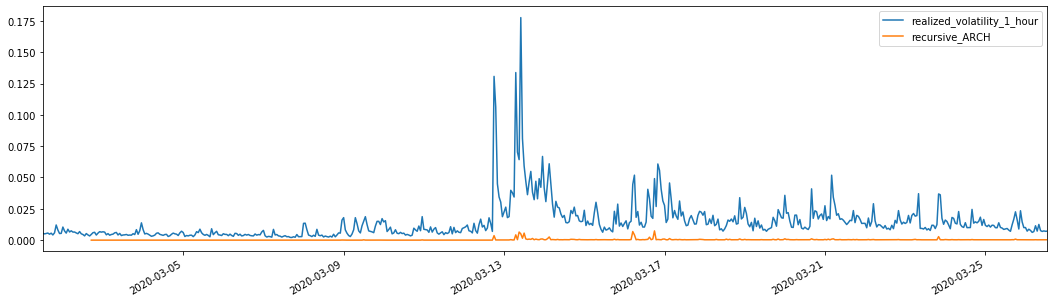

In [117]:
def recursive_forecast(pd_dataframe):     
    window = predict_lag
    model = 'ARCH'
    index = kline_test[1:].index
    end_loc = np.where(index >= kline_test.index[window])[0].min()
    forecasts = {}
    for i in range(len(kline_test[1:]) - window + 2):
        mod = arch_model(pd_dataframe['log_return'][1:], mean='AR', vol=model, dist='ged', p=1)
        res = mod.fit(last_obs=i+end_loc, disp='off', options={'ftol': 1e03})
        temp = res.forecast().variance
        fcast = temp.iloc[i + end_loc - 1]
        forecasts[fcast.name] = fcast

    forecasts = pd.DataFrame(forecasts).T
    pd_dataframe['recursive_{}'.format(model)] = forecasts['h.1']
    evaluate(pd_dataframe, 'realized_volatility_1_hour', 'recursive_{}'.format(model))

recursive_forecast(kline_test)

# 7、EGARCH建模

接下来就进行EGARCH建模

In [96]:
am_EGARCH = arch_model(training_egarch, mean='AR', vol='EGARCH', 
                       p=1, lags=3, o=1,q=1, dist='ged')
res_EGARCH = am_EGARCH.fit(disp=False, options={'ftol': 1e-01})
res_EGARCH.summary()

Iteration:      1,   Func. Count:     11,   Neg. LLF: -2455.1524130329417


<class 'statsmodels.iolib.summary.Summary'>
"""
                                AR - EGARCH Model Results                                 
==========================================================================================
Dep. Variable:                         log_return   R-squared:                       0.008
Mean Model:                                    AR   Adj. R-squared:                  0.005
Vol Model:                                 EGARCH   Log-Likelihood:                2455.48
Distribution:      Generalized Error Distribution   AIC:                          -4892.96
Method:                        Maximum Likelihood   BIC:                          -4850.82
                                                    No. Observations:                  798
Date:                            Wed, Jul 08 2020   Df Residuals:                      789
Time:                                    08:14:20   Df Model:                            9
                                    Mean Model                                   
=================================================================================
                     coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------------------
Const         -4.5141e-04  4.202e-04     -1.074      0.283 [-1.275e-03,3.721e-04]
log_return[1]     -0.0910  6.149e-02     -1.481      0.139    [ -0.212,2.948e-02]
log_return[2]     -0.0223  4.635e-02     -0.480      0.631    [ -0.113,6.858e-02]
log_return[3] -5.6424e-03  4.143e-02     -0.136      0.892 [-8.684e-02,7.555e-02]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega         -0.1598  8.838e-02     -1.808  7.058e-02  [ -0.333,1.342e-02]
alpha[1]       0.1000  4.136e-02      2.418  1.559e-02  [1.895e-02,  0.181]
gamma[1]      -0.1000  3.154e-02     -3.170  1.524e-03 [ -0.162,-3.817e-02]
beta[1]        0.9800  1.086e-02     90.242      0.000    [  0.959,  1.001]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             1.5000      0.343      4.378  1.199e-05 [  0.828,  2.172]
========================================================================

Covariance estimator: robust
"""

ARCH库提供的EGARCH波动率方程描述如下：

$$
\ln ^{\sigma_{l}^{2}}=\omega_{0}+\sum_{i=1}^{p} a_{1}\left(\left|e_{t-i}\right|-\sqrt{2 / \pi}\right)+\sum_{j=1}^{o} \gamma_{j} e_{t-j}+\sum_{k=1}^{q} \beta_{k} \ln ^{\sigma_{t-k}^{2}}
$$

代入$$
e_{t}=^{\varepsilon_{t}} / \sigma_{t}
$$

可以得到波动率的条件回归方程为：

$$
\ln ^{\sigma_{t}^{2}}=-0.159799+0.100011\left(\left.\right|^{\varepsilon_{t-1}} / \sigma_{t-1} \mid-\sqrt{2 / \pi}\right)-0.099991^{\varepsilon_{t-1}} / \sigma_{t-1}+0.98 \ln ^{\sigma_{t-1}^{2}}
$$

其中，对称项估计系数γ小于置信区间，说明比特币的收益率波动存在显著的“非对称性”。

结合拟合的预测波动率，与样本的已实现波动率进行比较，效果如下：

Mean Absolute Error (MAE): 0.0219
Mean Absolute Percentage Error (MAPE): 126
Root Mean Square Error (RMSE): 0.0295


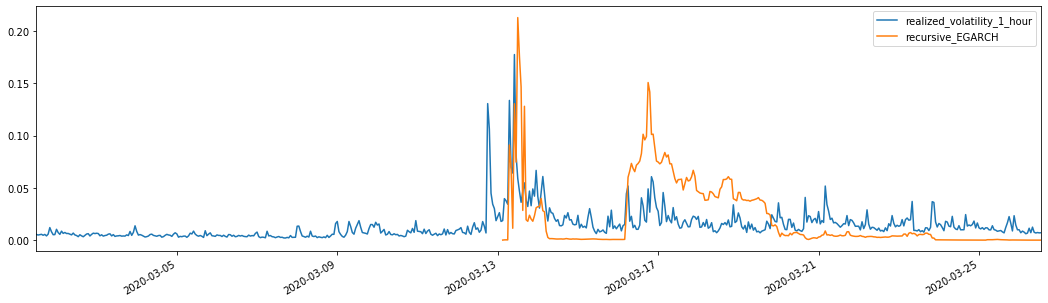

In [118]:
def recursive_forecast(pd_dataframe):     
    window = 280
    model = 'EGARCH'
    index = kline_test[1:].index
    end_loc = np.where(index >= kline_test.index[window])[0].min()
    forecasts = {}
    for i in range(len(kline_test[1:]) - window + 2):
        mod = arch_model(pd_dataframe['log_return'][1:], mean='AR', vol=model, 
                         lags=3, p=2, o=0, q=1, dist='ged')
        res = mod.fit(last_obs=i+end_loc, disp='off', options={'ftol': 1e03})
        temp = res.forecast().variance
        fcast = temp.iloc[i + end_loc - 1]
        forecasts[fcast.name] = fcast

    forecasts = pd.DataFrame(forecasts).T
    pd_dataframe['recursive_{}'.format(model)] = forecasts['h.1']
    evaluate(pd_dataframe, 'realized_volatility_1_hour', 'recursive_{}'.format(model))
    pd_dataframe['recursive_{}'.format(model)]

recursive_forecast(kline_test)

可以看到，EGARCH相比较ARCH和GARCH对波动更敏感，对波动率的拟合更出色。

# 8、波动率预测的评价

基于样本选择的是小时数据，向前一步预测即向前1个小时，我们选择三个模型前10小时的预测波动率，以RV为基准波动率，比较误差值如下：

In [119]:
compare_ARCH_X = pd.DataFrame()
compare_ARCH_X['original']=kline_test['realized_volatility_1_hour']

compare_ARCH_X['arch']=kline_test['recursive_ARCH']
compare_ARCH_X['arch_diff']=compare_ARCH_X['original']-np.abs(compare_ARCH_X['arch'])

compare_ARCH_X['garch']=kline_test['recursive_GARCH']
compare_ARCH_X['garch_diff']=compare_ARCH_X['original']-np.abs(compare_ARCH_X['garch'])

compare_ARCH_X['egarch']=kline_test['recursive_EGARCH']
compare_ARCH_X['egarch_diff']=compare_ARCH_X['original']-np.abs(compare_ARCH_X['egarch'])
compare_ARCH_X = compare_ARCH_X[280:]
compare_ARCH_X.head(10)

,original,arch,arch_diff,garch,garch_diff,egarch,egarch_diff
date,,,,,,,
2020-03-13 04:00:00+08:00,0.039796,0.000410,0.039386,0.019046,0.020750,0.000354,0.039442
2020-03-13 05:00:00+08:00,0.037765,0.000173,0.037591,0.003011,0.034754,0.000401,0.037364
2020-03-13 06:00:00+08:00,0.034429,0.000156,0.034273,0.002956,0.031473,0.000340,0.034089
2020-03-13 07:00:00+08:00,0.133740,0.004234,0.129506,0.034791,0.098949,0.091072,0.042668
2020-03-13 08:00:00+08:00,0.070220,0.000394,0.069825,0.190576,-0.120357,0.069111,0.001109
2020-03-13 09:00:00+08:00,0.064249,0.006472,0.057777,0.066352,-0.002103,0.011460,0.052789
2020-03-13 10:00:00+08:00,0.177593,0.005037,0.172556,0.102359,0.075234,0.130532,0.047061
2020-03-13 11:00:00+08:00,0.081091,0.001535,0.079556,0.022981,0.058110,0.074742,0.006349
2020-03-13 12:00:00+08:00,0.059117,0.005636,0.053481,0.008225,0.050892,0.212941,-0.153824


In [120]:
compare_ARCH_X_diff = pd.DataFrame(index=['ARCH','GARCH','EGARCH'], columns=['head 1 step', 'head 10 steps', 'head 100 steps'])
compare_ARCH_X_diff['head 1 step']['ARCH'] = compare_ARCH_X['arch_diff']['2020-03-13 04:00:00+08:00']
compare_ARCH_X_diff['head 10 steps']['ARCH'] = np.mean(compare_ARCH_X['arch_diff'][:10])
compare_ARCH_X_diff['head 100 steps']['ARCH'] = np.mean(compare_ARCH_X['arch_diff'][:100])
compare_ARCH_X_diff['head 1 step']['GARCH'] = compare_ARCH_X['garch_diff']['2020-03-13 04:00:00+08:00']
compare_ARCH_X_diff['head 10 steps']['GARCH'] = np.mean(compare_ARCH_X['garch_diff'][:10])
compare_ARCH_X_diff['head 100 steps']['GARCH'] = np.mean(compare_ARCH_X['garch_diff'][:100])
compare_ARCH_X_diff['head 1 step']['EGARCH'] = compare_ARCH_X['egarch_diff']['2020-03-13 04:00:00+08:00']
compare_ARCH_X_diff['head 10 steps']['EGARCH'] = np.mean(compare_ARCH_X['egarch_diff'][:10])
compare_ARCH_X_diff['head 100 steps']['EGARCH'] = np.abs(np.mean(compare_ARCH_X['egarch_diff'][:100]))
compare_ARCH_X_diff

,head 1 step,head 10 steps,head 100 steps
ARCH,0.0393856,0.0719949,0.028944
GARCH,0.02075,0.0247013,0.0218469
EGARCH,0.0394424,-0.00220146,0.00703015


做了几次试验，在前1个小时预测结果里，EGARCH的误差最小的几率比较大，但整体差异不是特别明显；短期预测效果里有一定明显区别；在长期预测里， EGARCH的预测能力最突出

In [121]:
compare_ARCH_X = pd.DataFrame()
compare_ARCH_X['Model'] = ['ARCH','GARCH','EGARCH']
compare_ARCH_X['RMSE'] = [get_rmse(kline_test['realized_volatility_1_hour'][280:320],kline_test['recursive_ARCH'][280:320]),
                          get_rmse(kline_test['realized_volatility_1_hour'][280:320],kline_test['recursive_GARCH'][280:320]),
                          get_rmse(kline_test['realized_volatility_1_hour'][280:320],kline_test['recursive_EGARCH'][280:320])]
compare_ARCH_X['MAPE'] = [get_mape(kline_test['realized_volatility_1_hour'][280:320],kline_test['recursive_ARCH'][280:320]),
                          get_mape(kline_test['realized_volatility_1_hour'][280:320],kline_test['recursive_GARCH'][280:320]),
                          get_mape(kline_test['realized_volatility_1_hour'][280:320],kline_test['recursive_EGARCH'][280:320])]
compare_ARCH_X['MASE'] = [get_mape(kline_test['realized_volatility_1_hour'][280:320],kline_test['recursive_ARCH'][280:320]),
                          get_mape(kline_test['realized_volatility_1_hour'][280:320],kline_test['recursive_GARCH'][280:320]),
                          get_mape(kline_test['realized_volatility_1_hour'][280:320],kline_test['recursive_EGARCH'][280:320])]

compare_ARCH_X

,Model,RMSE,MAPE,MASE
0,ARCH,0.051855,97.772640,97.772640
1,GARCH,0.041761,82.338067,82.338067
2,EGARCH,0.044885,82.598753,82.598753


从指标上看，GARCH和EGARCH相对ARCH来说有一定提升，但差距也不是特别明显。在多样本区间选择和验证后，EGARCH的性能会更优一些，这也是主要因为EGARCH很好地解释了样本所呈现出的异方差特性。

# 9、结论

通过以上简单的分析，可以发现比特币的对数收益率不服从正态分布，呈尖峰厚尾的特征，且波动具有聚集现象和杠杆效应，同时呈现明显的条件异方性。

在对对数收益率的预测评价里，ARMA模型的样本内静态预测能力要明显好于动态，可见滚动的方式明显优于迭代方式，且可以避免过度拟合和误差放大的问题。样本外的收益率很难预测，满足了市场的弱有效性假设。

此外，在处理比特币的厚尾现象时，即收益率的厚尾分布时，发现GED（广义误差）分布明显优于t分布和正态分布，可以提升对尾部风险的度量精度。同时，在预测波动性上，EGARCH对长期的波动率预测更有优势，很好地解释了样本所呈现出的异方差特性。模型拟合中的对称项估计系数小于置信区间，说明比特币的收益率波动存在显著的“非对称性”。

整个建模过程充满了各种大胆的假设，并且依赖有效性也没有做一致性识别，因此只能对一些现象做小心的求证。历史只能在统计上去支持对预测未来的概率，但准确率和性价比还有很长的路要走。

对比传统市场，比特币的高频数据可得性更容易，基于高频数据对其各类指标的“已实现”测度就变得简单且重要。如果非参数的测度可以为已发生行情提供快速观测，有参数的测度可以提高模型的输入精度，那么将已实现的非参数测度作为模型的“超参”，或许能建立更“完整”的模型。

但以上仅仅限于理论上YY，更高频的数据确实可以提供更精准的交易者行为分析，不仅能为金融理论模型提供更可靠的检验，还能为交易者提供更丰富的决策信息，甚至支撑对信息流和资金流的预判，辅助设计出更加精密的量化交易策略。而比特币的市场波动如此之大，太长的历史数据反而无法拟合出有效的决策信息，所以高频数据必然能为数字货币的投资者带来更强的市场优势。